# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 116000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (116000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [28]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [29]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [30]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [31]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [32]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(116000, 10)

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(100551, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.68189655172414

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100549, 10)


1    84354
0    16195
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
Last time I had licorice like this is when I visited Holland and got hooked on it.
I love this item for cooking--it is especially good in brownies, cakes--and just a little bit in hot cocoa is wonderful.
I suppose we are all creatures of habit. Mine is coffee, lot's of it. I like a well made percolator coffee, but years ago I discovered Tasters Choice. It's my favorite instant, hands down. Just put a teaspoons-worth in a coffee cup of water and nuke it in the microwave for 1:45 (well, in MY micro, anyway). The coffee is strong for some tastes; do you like espresso? Well, not that strong but definitely potent. Amazon sells it at ab

In [12]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [13]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
Last time I had licorice like this is when I visited Holland and got hooked on it.
I love this item for cooking--it is especially good in brownies, cakes--and just a little bit in hot cocoa is wonderful.
I suppose we are all creatures of habit. Mine is coffee, lot's of it. I like a well made percolator coffee, but years ago I discovered Tasters Choice. It's my favorite instant, hands down. Just put a teaspoons-worth in a coffee cup of water and nuke it in the microwave for 1:45 (well, in MY micro, anyway). The coffee is strong for some tastes; do you like espresso? Well, not that strong but definitely potent. Amazon sells it at about the sa

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this item for cooking--it is especially good in brownies, cakes--and just a little bit in hot cocoa is wonderful.


In [16]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this item for cooking it is especially good in brownies cakes and just a little bit in hot cocoa is wonderful 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████| 100549/100549 [01:50<00:00, 907.63it/s]


In [20]:
preprocessed_reviews[1500]

'love item cooking especially good brownies cakes little bit hot cocoa wonderful'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [21]:
## Similartly you can do preprocessing for review summary also.
# Splitting our input into Test and Train 
from sklearn.model_selection import TimeSeriesSplit
Y=final['Score']

y_train=Y[:70384]
y_test=Y[70384:]

print(y_train.shape)
print(y_test.shape)

X_train=preprocessed_reviews[:70384]
X_test=preprocessed_reviews[70384:]



(70384,)
(30165,)


# [4] Featurization

## [4.1] BAG OF WORDS

Important positive and Negetive Features

## [4.2] Bi-Grams and n-Grams.

In [96]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts_train = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts_train))
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])
#test data
final_bigram_counts_test = count_vect.fit_transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70384, 5000)
the number of unique words including both unigrams and bigrams  5000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30165, 5000)
the number of unique words including both unigrams and bigrams  5000


In [97]:
pre_mod=MaxAbsScaler().fit(final_bigram_counts_train)
std_bow_train=pre_mod.transform(final_bigram_counts_train)
std_bow_test=pre_mod.transform(final_bigram_counts_test)
print(std_bow_train.shape,'\n',std_bow_test.shape)

(70384, 5000) 
 (30165, 5000)


In [98]:
lr=LogisticRegression(random_state=42,n_jobs=-1,class_weight='balanced')
parameter={'C':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0],'penalty':['l1','l2']}
tss=TimeSeriesSplit(n_splits=5).split(std_bow_train)
score=make_scorer(f1_score,average='weighted')

gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_bow_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 22.9min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000000044934990>,
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [99]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))

Best Parameteres are as follows :  {'C': 1.0, 'penalty': 'l2'}
Best Accuracy : 90.12%


In [100]:
best_lr=LogisticRegression(C=1.0,penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_bow_train,y_train)
#test_bow=preprocessing.normalize(bow_test,norm='l1')
y_pred=best_lr.predict(std_bow_test)

print("F1 Score of test set : ",f1_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

F1 Score of test set :  83.4908015899966
Sparsity/Non-zero counts :  5000


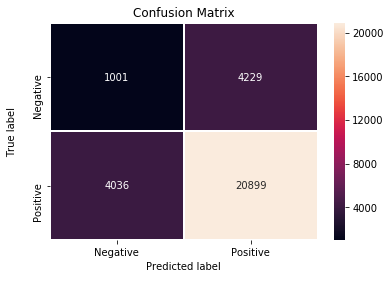

In [101]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

In [102]:
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))


              precision    recall  f1-score   support

           0       0.20      0.19      0.19      5230
           1       0.83      0.84      0.83     24935

   micro avg       0.73      0.73      0.73     30165
   macro avg       0.52      0.51      0.51     30165
weighted avg       0.72      0.73      0.72     30165

TPR = 0.838139 
 FPR = 0.808604 
 TNR = 0.191396 
 FNR = 0.161861


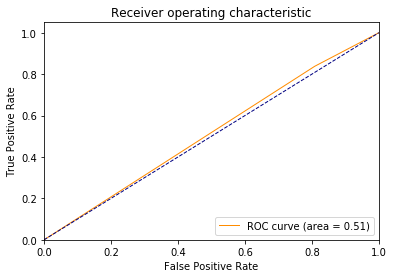

In [104]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [4.3] TF-IDF

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [22]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
bow_fnames=count_vect.get_feature_names()
final_counts_train = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

final_counts_test = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70384, 49158)
the number of unique words  49158
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30165, 49158)
the number of unique words  49158


In [23]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
pre_mod=MaxAbsScaler().fit(final_counts_train)
std_bow_train=pre_mod.transform(final_counts_train)
std_bow_test=pre_mod.transform(final_counts_test)
print(std_bow_train.shape,'\n',std_bow_test.shape)

(70384, 49158) 
 (30165, 49158)


In [24]:
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score

lr=LogisticRegression(random_state=42,n_jobs=-1,class_weight='balanced')
parameter={'C':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0],'penalty':['l1','l2']}
tss=TimeSeriesSplit(n_splits=5).split(std_bow_train)
score=make_scorer(f1_score,average='weighted')

gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_bow_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effec

C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklea

C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Simha\Anaconda3\lib\site-packages\sklea

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000000001CB418E0>,
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [26]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))
print(gscv.cv_results_['mean_test_score'].shape)

Best Parameteres are as follows :  {'C': 1.0, 'penalty': 'l2'}
Best Accuracy : 90.28%
(16,)


In [32]:
best_lr=LogisticRegression(C=1.0,penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_bow_train,y_train)
#test_bow=preprocessing.normalize(bow_test,norm='l1')
y_pred=best_lr.predict(std_bow_test)

print("F1 Score of test set : ",f1_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

F1 Score of test set :  93.97005593945377
Sparsity/Non-zero counts :  49158


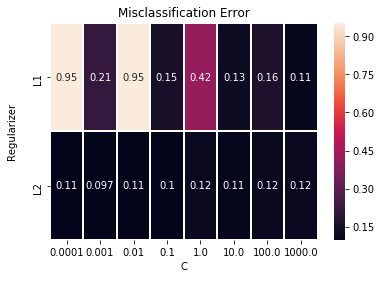

In [39]:
y1=gscv.cv_results_['mean_test_score'][:8]
y2=gscv.cv_results_['mean_test_score'][8:]
y1=1-y1
y2=1-y2
heatmap = sn.heatmap([y1,y2], linewidths=1,# cmap=color,
                 xticklabels=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0], yticklabels=['L1','L2'],annot=True).set_title("Misclassification Error")
plt.xlabel("C\n")
plt.ylabel("Regularizer\n")
plt.show()

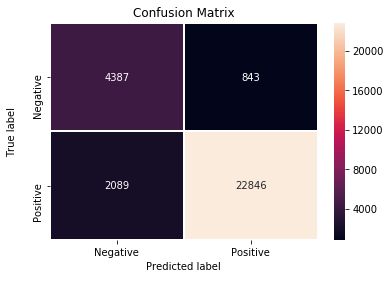

In [33]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      5230
           1       0.96      0.92      0.94     24935

   micro avg       0.90      0.90      0.90     30165
   macro avg       0.82      0.88      0.84     30165
weighted avg       0.91      0.90      0.91     30165

TPR = 0.916222 
 FPR = 0.161185 
 TNR = 0.838815 
 FNR = 0.083778


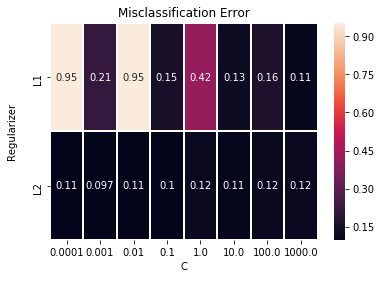

In [42]:
def plot_error_vs_c_r(gsv):
    x1=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
    y1=gsv.cv_results_['mean_test_score'][:8]
    y2=gsv.cv_results_['mean_test_score'][8:]
    y1=1-y1
    y2=1-y2
    heatmap = sn.heatmap([y1,y2], linewidths=1,# cmap=color,
                 xticklabels=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0], yticklabels=['L1','L2'],annot=True).set_title("Misclassification Error")
    plt.xlabel("C\n")
    plt.ylabel("Regularizer\n")
    plt.show()
plot_error_vs_c_r(gscv)

In [36]:
Conf_matrix

array([[ 4387,   843],
       [ 2089, 22846]], dtype=int64)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [94]:
# SPARSITY
##########
#Below code shows how sparsity increase as we increase lambda or decrease C under L1 regularizer
from decimal import *
Non_Zero_Percent=[]
for each in (100,10,1,0.1,0.01,0.009,0.001,0.0001):
    model = LogisticRegression(penalty='l1',C=each,random_state=42, solver='liblinear',n_jobs=-1)
    model.fit(std_bow_train, y_train)
    
    pred=model.predict(std_bow_test)
    print("\n C : %0.4f"%(each))
    print("F1 Score of test set :%0.3f "%(f1_score(y_test,pred)*100))
    print("Sparsity/Non-zero counts : ",np.count_nonzero(model.coef_))
    Non_Zero_Percent.append((Decimal((np.count_nonzero(model.coef_))/Decimal(model.coef_.shape[1])))*100)


 C : 100.0000
F1 Score of test set :92.617 
Sparsity/Non-zero counts :  13579

 C : 10.0000
F1 Score of test set :94.247 
Sparsity/Non-zero counts :  10539

 C : 1.0000
F1 Score of test set :94.890 
Sparsity/Non-zero counts :  3348

 C : 0.1000
F1 Score of test set :93.568 
Sparsity/Non-zero counts :  347

 C : 0.0100
F1 Score of test set :90.529 
Sparsity/Non-zero counts :  15

 C : 0.0090
F1 Score of test set :90.509 
Sparsity/Non-zero counts :  9

 C : 0.0010
F1 Score of test set :90.508 
Sparsity/Non-zero counts :  0

 C : 0.0001
F1 Score of test set :90.508 
Sparsity/Non-zero counts :  0


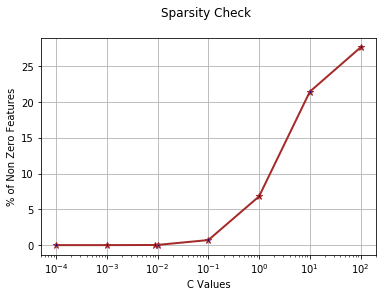

<Figure size 432x288 with 0 Axes>

In [95]:
#plotting Misclassification Error
C=[100,10,1,0.1,0.01,0.009,0.001,0.0001]
error=plt.semilogx(C,Non_Zero_Percent, marker='*',color='brown',linewidth=2,ls='-',markerfacecolor='darkblue',markersize=7.0)
plt.ylabel('% of Non Zero Features')
plt.xlabel('C Values')
plt.title('Sparsity Check \n')
plt.gca().set_facecolor('xkcd:white')
plt.grid() 
fig = plt.figure()

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

Epsilon creation and addition

Here we are adding small epsilon and calculating those weights and we then alculate difference b/w them and find out outliers from the change

In [85]:
pre_weights=best_lr.coef_
print(pre_weights.size)

49158


In [89]:
# Epsilon creation and addition
x_eps_train=std_bow_train
#adding noise
x_eps_train.data=x_eps_train.data+0.01

In [90]:
best_wlr=LogisticRegression(C=10.0,penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_wlr.fit(x_eps_train,y_train)
#test_bow=preprocessing.normalize(bow_test)
y_pred=best_wlr.predict(std_bow_test)

print("F1 Score of test set : ",f1_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_wlr.coef_))

post_weights=best_wlr.coef_
print(post_weights[:20])
print(post_weights.size)

F1 Score of test set :  93.71682861108843
Sparsity/Non-zero counts :  49158
[[-1.26550087e+00  2.77939964e+00  3.20706473e-01 ... -6.92321610e-01
   5.56470167e-04  2.51990787e-01]]
49158


[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
[0, 867, 1632, 2425, 3167, 3870, 4572, 5330, 6197, 6988, 7815, 8719, 9650, 10599, 11625, 12700]


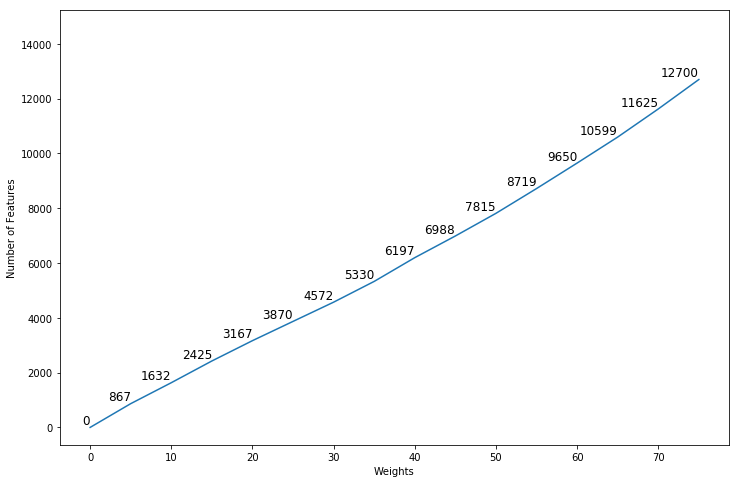

In [91]:
# Elbow method will start from here
weights_diff=(abs(pre_weights-post_weights)/abs(pre_weights))*100
w_percent=[]
for each in weights_diff[0]:
    w_percent.append(float('{0:.3s}'.format(str(each))))
Weights=[]
weights_f=[]
feats=[]
   
for each in np.arange(0,80,5):
    features = list(filter(lambda x: float(x) < each, w_percent))
    weights_f.append(each)
    feats.append(len(features))
    
print(weights_f)
print(feats)
df=pd.DataFrame({'Weight':weights_f,'Features':feats},index=None)
w_f=zip(weights_f,feats)

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(sorted(weights_f),sorted(feats))

for xy in zip(weights_f,feats):
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data',ha="right", va="bottom",fontsize='12')

plt.xlabel('Weights')
plt.ylabel('Number of Features')
plt.gca().set_ylim(top=(max(feats)+0.2*max(feats)))
plt.show()


The Features whose percentage change are less than the Threshold Value : 3167

The Features whose percentage change are more than the Threshold Value : 45857


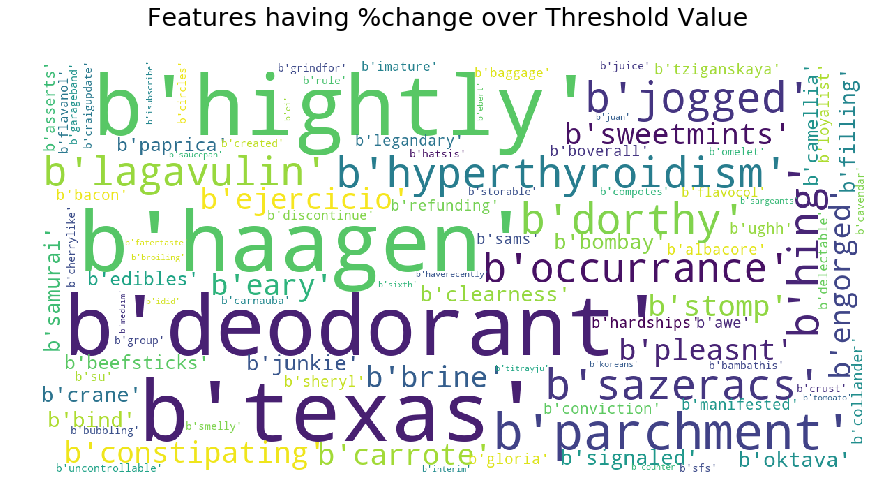

In [93]:
#From the above plot we can't tell dimensions percentage.So, we choose a random value 20% is having multicollinearity and we can cosider it as threshold value
print ('The Features whose percentage change are less than the Threshold Value : %d'%len(list(filter(lambda x: float(x) < 20, w_percent))))
print ('\nThe Features whose percentage change are more than the Threshold Value : %d'%len(list(filter(lambda x: float(x) > 20, w_percent))))

Threshold_Features = list(filter(lambda x: float(x) > 20, w_percent))

weight_threshold=np.take(pre_weights,Threshold_Features)
threshold_f=np.take(bow_fnames,weight_threshold.argsort())

import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
Crossed_threshold=[]
for each in threshold_f:
    Crossed_threshold.append(each.encode('utf-8'))

wordcloud = WordCloud(    background_color ='white',
                          stopwords=stopwords.words(),
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          random_state=42
                         ).generate(str(Crossed_threshold))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Features having %change over Threshold Value \n'
          , fontsize=25,fontname='cursive',color='black')
plt.show()
#below plot shows us all the features which are having multicollinearity 

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation
# Implemented this in below section 5.1.3.2

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [84]:
coef = gscv.best_estimator_.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : bow_fnames, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')
print(coeff_df.tail(20).to_string(index=False))


-Top 20 positive-
Word  Coefficient
     good    11.260399
     best    10.262224
delicious     8.655675
    great     7.548230
    loves     6.726481
  perfect     6.295505
excellent     5.993300
     nice     5.741195
wonderful     5.601186
    tasty     4.978527
  amazing     4.924480
   smooth     4.434944
     love     4.432029
   highly     4.399120
     beat     4.340379
  awesome     4.257142
     easy     4.254421
  pleased     4.250935
    yummy     4.227952
    happy     4.027389

-Top 20 negative-
Word  Coefficient
       nothing    -3.643993
 unfortunately    -3.807390
          poor    -3.813445
        hoping    -3.839866
     tasteless    -3.915850
          weak    -3.993045
  disappointed    -4.103664
         china    -4.228523
         threw    -4.264562
         stick    -4.354778
 disappointing    -4.391123
         stale    -4.431107
           rip    -4.559565
      terrible    -5.081669
      horrible    -5.153241
disappointment    -5.258684
         bland    

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Implemented this in below section 5.2.2

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [43]:
# Please write all the code with proper documentation

In [44]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
tf_fnames=tf_idf_vect.get_feature_names()
final_tf_idf_train = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
#applying same on test data
final_tf_idf_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70384, 41434)
the number of unique words including both unigrams and bigrams  41434
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30165, 41434)
the number of unique words including both unigrams and bigrams  41434


In [45]:
pre_mod=MaxAbsScaler().fit(final_tf_idf_train)
std_tfidf_train=pre_mod.transform(final_tf_idf_train)
std_tfidf_test=pre_mod.transform(final_tf_idf_test)
print(std_tfidf_train.shape,'\n',std_tfidf_test.shape)

(70384, 41434) 
 (30165, 41434)


In [46]:
tss=TimeSeriesSplit(n_splits=5).split(std_tfidf_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)
gscv.fit(std_tfidf_train,y_train)
print('*'*50)
print("\nThe Best parameters are as follows :")
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.3min finished


**************************************************

The Best parameters are as follows :
Best Parameteres are as follows :  {'C': 1.0, 'penalty': 'l2'}
Best Accuracy : 91.84%


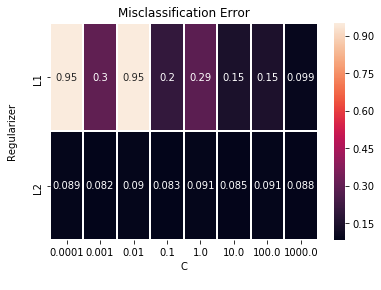

In [47]:
plot_error_vs_c_r(gscv)

In [48]:
best_lr=LogisticRegression(C=1.0,penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_tfidf_train,y_train)
#test_bow=preprocessing.normalize(bow_test,norm='l1')
y_pred=best_lr.predict(std_tfidf_test)

print("F1 Score of test set : ",f1_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

F1 Score of test set :  95.36246033683182
Sparsity/Non-zero counts :  41434


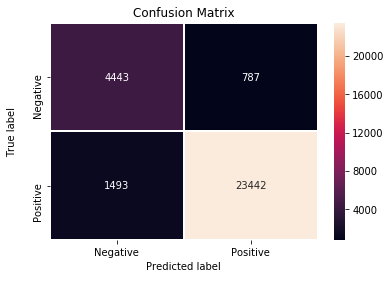

In [49]:
Conf_matrix=confusion_matrix(y_test, y_pred)
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      5230
           1       0.97      0.94      0.95     24935

   micro avg       0.92      0.92      0.92     30165
   macro avg       0.86      0.89      0.87     30165
weighted avg       0.93      0.92      0.93     30165

TPR = 0.940124 
 FPR = 0.150478 
 TNR = 0.849522 
 FNR = 0.059876


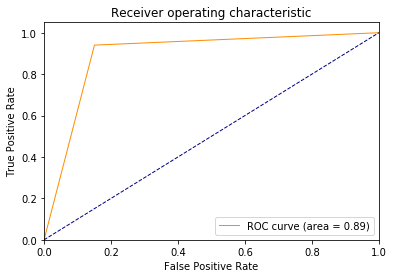

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [52]:
# Implemented this in below section 5.2.3.2

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [53]:
# Please write all the code with proper documentation

In [54]:
coef = gscv.best_estimator_.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : tf_fnames, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')
print(coeff_df.tail(20).to_string(index=False))


-Top 20 positive-
Word  Coefficient
       delicious     7.476744
            best     6.137815
            love     6.031021
           great     5.809706
           loves     5.194858
         perfect     4.969400
not disappointed     4.855347
            good     4.700388
       excellent     4.612770
       wonderful     4.280180
            nice     3.999630
         amazing     3.843183
         pleased     3.597391
           yummy     3.485433
           happy     3.299272
highly recommend     3.244331
         awesome     3.230479
           thank     3.106810
          hooked     3.091654
            glad     3.061192

-Top 20 negative-
Word  Coefficient
           bad    -3.083439
  not purchase    -3.097479
 unfortunately    -3.142828
     not happy    -3.164220
         stale    -3.181295
 not recommend    -3.373612
         threw    -3.406576
          weak    -3.435869
           rip    -3.470582
      horrible    -3.574421
         bland    -3.612072
     two stars    

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [55]:
# Implemented this in below section 5.3.2

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [56]:
# Please write all the code with proper documentation

In [57]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [58]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_train.wv.most_similar('worst'))
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
    print(w2v_model_test.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_test.wv.most_similar('worst'))    
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8264318704605103), ('fantastic', 0.8264236450195312), ('terrific', 0.809655487537384), ('awesome', 0.8008347153663635), ('excellent', 0.8005866408348083), ('wonderful', 0.7530359029769897), ('perfect', 0.7369937896728516), ('decent', 0.7100952863693237), ('fabulous', 0.7061886787414551), ('nice', 0.684603214263916)]
[('greatest', 0.7711035013198853), ('best', 0.7353250980377197), ('tastiest', 0.6957564353942871), ('nastiest', 0.6695903539657593), ('disgusting', 0.6474093198776245), ('closest', 0.6460716724395752), ('horrible', 0.6171910762786865), ('softest', 0.5981003642082214), ('smoothest', 0.5741804242134094), ('nicest', 0.572853147983551)]
[('awesome', 0.832767903804779), ('fantastic', 0.8180146217346191), ('excellent', 0.8095978498458862), ('good', 0.787588357925415), ('wonderful', 0.7599188089370728), ('amazing', 0.7482303380966187), ('perfect', 0.7233008146286011), ('terrific', 0.7193007469177246), ('fabulous', 0.6725587248802185), ('nice', 0.6510787606239319)]
[('n

In [59]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  15774
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']
number of words that occured minimum 5 times  10505
sample words  ['glad', 'found', 'larger', 'bag', 'best', 'coffee', 'ever', 'go', 'longer', 'reorder', 'follow', 'directions', 'not', 'add', 'sugar', 'sweetner', 'cream', 'milk', 'puts', 'starbucks', 'shame', 'still', 'think', 'keurig', 'idea', 'thing', 'since', 'grinder', 'problems', 'machines', 'put', 'good', 'get', 'great', 'job', 'customer', 'service', 'experience', 'buying', 'tully', 'roast', 

In [60]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 70384/70384 [06:32<00:00, 179.47it/s]


70384
50


In [61]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 30165/30165 [02:54<00:00, 172.66it/s]


30165
50


In [62]:
pre_mod=MaxAbsScaler().fit(sent_vectors_train)
std_aw2v_train=pre_mod.transform(sent_vectors_train)
std_aw2v_test=pre_mod.transform(sent_vectors_test)
print(std_aw2v_train.shape,'\n',std_aw2v_test.shape)

(70384, 50) 
 (30165, 50)


In [63]:
tss=TimeSeriesSplit(n_splits=5).split(std_aw2v_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)
gscv.fit(std_aw2v_train,y_train)

print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.9min finished


Best Parameteres are as follows :  {'C': 1000.0, 'penalty': 'l1'}
Best Accuracy : 82.53%


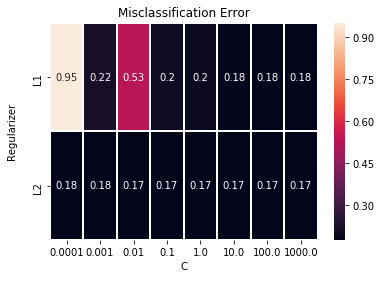

In [64]:
plot_error_vs_c_r(gscv)

In [65]:
best_lr=LogisticRegression(C=1000.0,penalty='l1',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_aw2v_train,y_train)
#test_bow=preprocessing.normalize(bow_test,norm='l1')
y_pred=best_lr.predict(std_aw2v_test)

print("F1 Score of test set : ",f1_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

F1 Score of test set :  87.33683749452476
Sparsity/Non-zero counts :  50


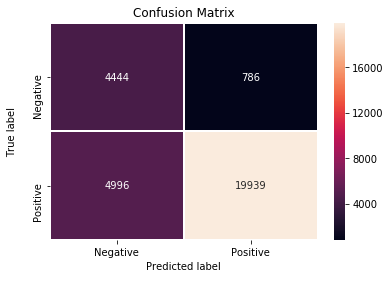

In [66]:
Conf_matrix=confusion_matrix(y_test, y_pred)
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred)) 
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.47      0.85      0.61      5230
           1       0.96      0.80      0.87     24935

   micro avg       0.81      0.81      0.81     30165
   macro avg       0.72      0.82      0.74     30165
weighted avg       0.88      0.81      0.83     30165

TPR = 0.799639 
 FPR = 0.150287 
 TNR = 0.849713 
 FNR = 0.200361


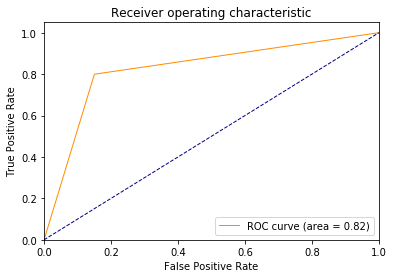

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [69]:
# Please write all the code with proper documentation

In [70]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [71]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████| 70384/70384 [1:31:32<00:00, 12.81it/s]


In [72]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 30165/30165 [40:01<00:00, 12.56it/s]


In [73]:
pre_mod=MaxAbsScaler().fit(tfidf_sent_vectors_train)
std_taw2v_train=pre_mod.transform(tfidf_sent_vectors_train)
std_taw2v_test=pre_mod.transform(tfidf_sent_vectors_test)
print(std_taw2v_train.shape,'\n',std_taw2v_test.shape)

(70384, 50) 
 (30165, 50)


In [74]:
tss=TimeSeriesSplit(n_splits=5).split(std_taw2v_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)
gscv.fit(std_taw2v_train,y_train)
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.8min finished


Best Parameteres are as follows :  {'C': 1.0, 'penalty': 'l2'}
Best Accuracy : 80.62%


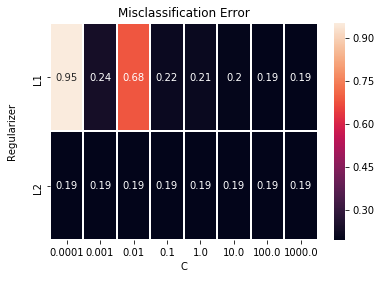

In [75]:
plot_error_vs_c_r(gscv)

In [76]:
best_lr=LogisticRegression(C=100.0,penalty='l1',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_taw2v_train,y_train)
#test_bow=preprocessing.normalize(bow_test,norm='l1')
y_pred=best_lr.predict(std_taw2v_test)

print("F1 Score of test set : ",f1_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

F1 Score of test set :  85.806224102971
Sparsity/Non-zero counts :  50


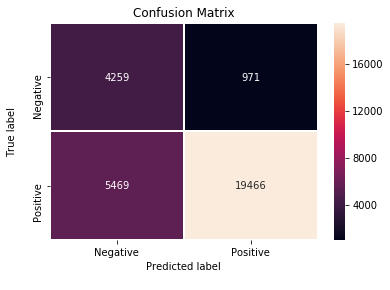

In [77]:
Conf_matrix=confusion_matrix(y_test, y_pred)
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
plt.show()

In [78]:
print(classification_report(y_test, y_pred)) 
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.44      0.81      0.57      5230
           1       0.95      0.78      0.86     24935

   micro avg       0.79      0.79      0.79     30165
   macro avg       0.70      0.80      0.71     30165
weighted avg       0.86      0.79      0.81     30165

TPR = 0.780670 
 FPR = 0.185660 
 TNR = 0.814340 
 FNR = 0.219330


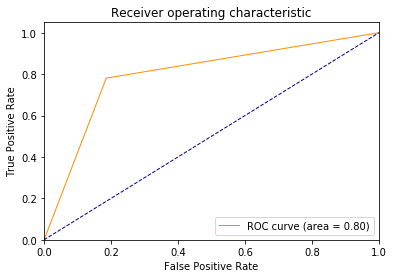

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [80]:
# Please write all the code with proper documentation
# Implemented this in below section 5.4.1

# [6] Conclusions

In [81]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=["Vectorizer","Regularizer","C Value","Accuracy/F1-score"]

x.add_row(['BOW','L2','1.0','93.97'])
x.add_row(['TFIDF','L2','1.0','95.36'])
x.add_row(['Avg-W2V','L1','1000.0','87.41'])
x.add_row(['Tfidf weighted W2V','L1','100.0','85.66'])
print('** Conclusion : Accuracy for Amazon review dataset with different vectorizers \n')
print(x)

** Conclusion : Accuracy for Amazon review dataset with different vectorizers 

+--------------------+-------------+---------+-------------------+
|     Vectorizer     | Regularizer | C Value | Accuracy/F1-score |
+--------------------+-------------+---------+-------------------+
|        BOW         |      L2     |   1.0   |       93.97       |
|       TFIDF        |      L2     |   1.0   |       95.36       |
|      Avg-W2V       |      L1     |  1000.0 |       87.41       |
| Tfidf weighted W2V |      L1     |  100.0  |       85.66       |
+--------------------+-------------+---------+-------------------+
